In [1]:
import logging

import json
import numpy as np
import scipy.linalg as sl
import scipy.sparse as sps
import scipy.special as ss
from pkg_resources import Requirement, resource_filename
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from sksparse.cholmod import cholesky

import enterprise
from enterprise import constants as const
from enterprise import signals as sigs  # noqa: F401
from enterprise.signals.gp_bases import (  # noqa: F401
    createfourierdesignmatrix_dm,
    createfourierdesignmatrix_env,
    createfourierdesignmatrix_eph,
    createfourierdesignmatrix_ephem,
    createfourierdesignmatrix_red,
)
from enterprise.signals.gp_priors import powerlaw, turnover  # noqa: F401
from enterprise.signals.parameter import function

logger = logging.getLogger(__name__)
#import numpy as np
#from enterprise import constants as const
from enterprise.signals import (deterministic_signals, parameter, signal_base,
                                utils)

from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import patheffects
from matplotlib import text

import healpy as hp
from healpy.newvisufunc import projview, newprojplot


In [2]:
cd /scratch/na00078/15yr_data

/scratch/na00078/15yr_data


In [3]:
psrs = []
rms_vals = []

f = open('/scratch/na00078/15yr_data/15yr_rms.json')
vals = json.load(f)
for i in vals:
    psr = i
    rms = (vals[i])
    psrs.append(psr)
    rms_vals.append(rms)

psrs,rms_vals = zip(*sorted(zip(psrs,rms_vals)))
print(psrs,rms_vals)

('B1855409', 'B1937+21', 'B1953+29', 'J0023+0923', 'J0030+0451', 'J034044130', 'J0406+3039', 'J0437-4715', 'J050940856', 'J0557+1551', 'J0605+3757', 'J0610-2100', 'J0613-0200', 'J0614-3329', 'J063645128', 'J0645+5158', 'J0709+0458', 'J0740+6620', 'J0931-1902', 'J1012+5307', 'J1012-4235', 'J1022+1001', 'J1024-0719', 'J1125+7819', 'J1312+0051', 'J1453+1902', 'J1455-3330', 'J1600-3053', 'J1614-2230', 'J1630+3734', 'J1640+2224', 'J1643-1224', 'J1705-1903', 'J1713+0747', 'J1719-1438', 'J1730-2304', 'J1738+0333', 'J1741+1351', 'J1744-1134', 'J1745+1017', 'J1747-4036', 'J1751-2857', 'J1802-2124', 'J1811-2405', 'J1832-0836', 'J1843-1113', 'J1853+1303', 'J1903+0327', 'J1909-3744', 'J191041256', 'J1911+1347', 'J1918-0642', 'J1923+2515', 'J1944-0907', 'J1946+3417', 'J2010-1323', 'J2017+0603', 'J2033+1734', 'J2043+1711', 'J2124-3358', 'J2145-0750', 'J2214+3000', 'J2229-2643', 'J2234+0611', 'J2234+0944', 'J2302+4442', 'J2317+1439', 'J2322+2057') (0.241, 0.015, 0.948, 0.585, 0.491, 2.24, 0.416, 0.08

In [4]:
def create_gw_antenna_pattern(pos, gwtheta, gwphi):
        """
        Function to create pulsar antenna pattern functions as defined
        in Ellis, Siemens, and Creighton (2012).
        :param pos: Unit vector from Earth to pulsar
        :param gwtheta: GW polar angle in radians
        :param gwphi: GW azimuthal angle in radians

        :return: (fplus, fcross, cosMu), where fplus and fcross
                 are the plus and cross antenna pattern functions
                 and cosMu is the cosine of the angle between the
                 pulsar and the GW source.
        """

        # use definition from Sesana et al 2010 and Ellis et al 2012
        m = np.array([np.sin(gwphi), -np.cos(gwphi), 0.0])
        n = np.array([-np.cos(gwtheta) * np.cos(gwphi), -np.cos(gwtheta) * np.sin(gwphi), np.sin(gwtheta)])
        omhat = np.array([-np.sin(gwtheta) * np.cos(gwphi), -np.sin(gwtheta) * np.sin(gwphi), -np.cos(gwtheta)])

        fplus = 0.5 * (np.dot(m, pos) ** 2 - np.dot(n, pos) ** 2) / (1 + np.dot(omhat, pos))
        fcross = (np.dot(m, pos) * np.dot(n, pos)) / (1 + np.dot(omhat, pos))
        cosMu = -np.dot(omhat, pos)
        #Introducing amplitude (F+^2 + Fx^2)
        amplitude = (np.sqrt(np.power(fplus,2) + np.power(fcross,2)))
        
        return fplus, fcross, cosMu, amplitude


In [5]:
RA = 248.26 * np.pi/180  #for GW source
DEC = 23.82 * np.pi/180
gwtheta = np.pi/2 - DEC
gwphi = RA

psrnames = []
ampli = []
psr_thetas = []
psr_phis = []

f = open('NG15yr_pulsar_position.json')
data = json.load(f)
#print(data)

for i in data:
    
    psrname = i
    psrnames.append(psrname)
    #pos = [np.cos(DEC1)* np.cos(RA1), np.cos(DEC1)* np.sin(RA1), np.sin(DEC1)]
    pos = data[i][0]
    #print(data[i][1])
    psr_theta = data[i][1][0]
    psr_phi = data[i][1][1]
    psr_thetas.append(psr_theta)
    psr_phis.append(psr_phi)
    
    
#Function call
    
    outputs = create_gw_antenna_pattern(pos, gwtheta, gwphi)
    #print(outputs[3])
    ampli.append(outputs[3])

print(psrnames,"\n","\n",ampli)
#print(psrnames)
#print(psr_thetas)
#print(psr_phis)

#print(trial)
# Iterating through the json
# list
#for i in data['emp_details']:
 #   print(i)

['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923', 'J0030+0451', 'J0340+4130', 'J0406+3039', 'J0437-4715', 'J0509+0856', 'J0557+1551', 'J0605+3757', 'J0610-2100', 'J0613-0200', 'J0614-3329', 'J0636+5128', 'J0645+5158', 'J0709+0458', 'J0740+6620', 'J0931-1902', 'J1012+5307', 'J1012-4235', 'J1022+1001', 'J1024-0719', 'J1125+7819', 'J1312+0051', 'J1453+1902', 'J1455-3330', 'J1600-3053', 'J1614-2230', 'J1630+3734', 'J1640+2224', 'J1643-1224', 'J1705-1903', 'J1713+0747', 'J1719-1438', 'J1730-2304', 'J1738+0333', 'J1741+1351', 'J1744-1134', 'J1745+1017', 'J1747-4036', 'J1751-2857', 'J1802-2124', 'J1811-2405', 'J1832-0836', 'J1843-1113', 'J1853+1303', 'J1903+0327', 'J1909-3744', 'J1910+1256', 'J1911+1347', 'J1918-0642', 'J1923+2515', 'J1944+0907', 'J1946+3417', 'J2010-1323', 'J2017+0603', 'J2033+1734', 'J2043+1711', 'J2124-3358', 'J2145-0750', 'J2214+3000', 'J2229+2643', 'J2234+0611', 'J2234+0944', 'J2302+4442', 'J2317+1439', 'J2322+2057'] 
 
 [0.9007573428100528, 0.8690129584848839, 0.854515

12288
[48.199999999999996, 3.0, 189.6, 117.0, 98.2, 448.00000000000006, 83.2, 16.2, 263.8, 280.4, 355.6, 263.8, 130.8, 208.8, 119.19999999999999, 164.6, 621.0, 158.4, 368.0, 156.20000000000002, 416.2, 85.6, 226.39999999999998, 434.99999999999994, 402.4, 485.20000000000005, 420.0, 50.6, 135.4, 216.0, 85.6, 113.39999999999999, 38.4, 17.8, 294.8, 237.4, 112.6, 67.60000000000001, 51.6, 140.6, 257.0, 364.8, 195.6, 131.4, 117.0, 115.99999999999999, 138.2, 112.20000000000002, 26.200000000000003, 81.2, 38.4, 200.0, 211.0, 198.2, 101.4, 213.79999999999998, 92.80000000000001, 275.4, 59.8, 331.2, 137.6, 168.79999999999998, 254.6, 54.2, 88.8, 513.8, 142.79999999999998, 229.6] 

[1.402309470247295, 1.1961263783076368, 1.0644403654535461, 1.4069106122091741, 1.4859553047915817, 0.8462650016545497, 1.0356472271711716, 2.3955117826044, 1.4147587858403063, 1.2944228618491012, 0.9082694740047054, 1.9374499528382565, 1.6059318281165829, 2.1554529590061486, 0.6722426580015057, 0.6637344702612409, 1.483861

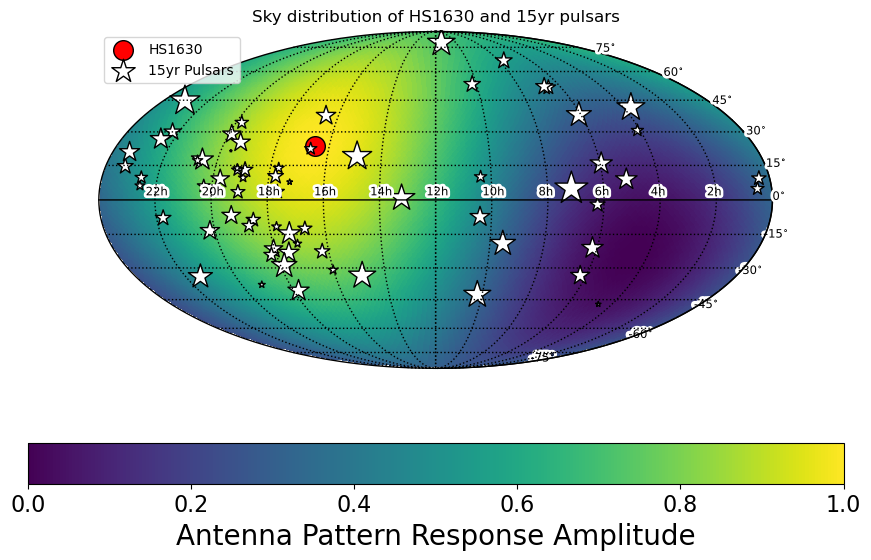

In [6]:
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
print(NPIX)
m = np.arange(NPIX)

from numpy import cos, sin
theta_pix, phi_pix = hp.pix2ang(nside=32, ipix=m)
pos_pix = np.array([sin(theta_pix)*cos(phi_pix), sin(theta_pix)*sin(phi_pix), cos(theta_pix)])

_, _, _, amp_pix = create_gw_antenna_pattern(pos_pix, gwtheta, gwphi)


hp.mollview(amp_pix,title="Sky distribution of HS1630 and 15yr pulsars", cbar = None, cmap = 'viridis', min = 0, max = 1, rot = 180)
hp.graticule(15,30)

hp.visufunc.projscatter(gwtheta, gwphi,marker='o',color='red',edgecolors='k',s=200, label='HS1630')

rms_values = []
#rms = rms_vals*100
for j in range(0,68):
    rms = rms_vals[j] * 200
    rms_values.append(rms)
#print(rms_vals[68] * 100)
#hp.visufunc.projscatter(psr_thetas, psr_phis,marker='*',color='white',edgecolors='k',s=200, label = '15yr Pulsars')
hp.visufunc.projscatter(psr_thetas, psr_phis,marker='*',color='white',edgecolors='k',s=rms_values, label = '15yr Pulsars')

print(rms_values,"\n")
print(psr_thetas)

##################################################33

plt.rc('xtick',**{'labelsize':16})
plt.rc('ytick',**{'labelsize':16})
plt.rc('axes',**{'labelsize':20,'titlesize':18})

#mollview tick labels
#tick_labels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h']
#y_ticks = ['$-75^\circ$', '$-60^\circ$', '$-45^\circ$','$-30^\circ$','$-15^\circ$','$0^\circ$',
#       '$15^\circ$','$30^\circ$','$45^\circ$','$60^\circ$','$75^\circ$',]

#colorbar tick labels
cbar_ticks = [2e-15, 3e-15, 4e-15, 5e-15, 6e-15, 7e-15, 8e-15, 9e-15, 1e-14]
cbar_labels = ['$2 \times 10^{-15}$', '$3 \times 10^{-15}$', '$4 \times 10^{-15}$', ' ', '$6 \times 10^{-15}$', ' ',
           ' ' , ' ', '$10^{-14}$']

'''
#assigning number of pixels to plot
npix = hp.nside2npix(nside)

#creating mollview plot
mv = hp.mollview(skymap_smoothed, title="", cbar = None , cmap = 'viridis_r', rot = 180, norm='log',
#                        min = min(skymap11[0:768,3]), max = max(skymap11[0:768,3]),   
#                        bgcolor='white', badcolor = 'white',
                )
#drawing graticule (lines of latitude and longitude)
hp.graticule(15, 30)

#plotting candidates as points on the map
hp.visufunc.projscatter(data['Right Ascension (Decimal Degrees)'], data['Declination (Decimal Degrees)'], #data[2], data[3], 
                    lonlat=True, marker='*', color='w',edgecolors='r',s=200, zorder = 2
                       )
'''
for i in range(2,24,2):
        text = hp.projtext( i*180/12+5, 2,  str(i)+'h', lonlat=True, coord='G', fontsize = 'small', fontweight = 20, zorder = 1)
        text.set_path_effects([patheffects.withStroke(linewidth=4, foreground='w')])
    #plotting dec labels
for i in range(-75,0,15):
        text = hp.projtext( 360, i+7*i/75,  str(i)+r'$^{\circ}$', lonlat=True, coord='G', fontsize = 'small', fontweight = 20, zorder = 1)
        text.set_path_effects([patheffects.withStroke(linewidth=5, foreground='w')])
for i in range(0,90,15):
        text = hp.projtext( 360, i-3*i/75,  str(i)+r'$^{\circ}$', lonlat=True, coord='G', fontsize = 'small', fontweight = 20, zorder = 10)
        text.set_path_effects([patheffects.withStroke(linewidth=4, foreground='w')])
        
#Making colorbar for background map
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, orientation = 'horizontal', label = 'Antenna Pattern Response Amplitude' 
                    #ticks = cbar_ticks, pad = 0.05
                   )
    
###########################################################33   
plt.legend()
plt.show()
#

(0.9007573428100528, 0.8690129584848839, 0.8545155845604547, 0.3241464894393414, 0.2936922029079196, 0.300323942082395, 0.2121460623855063, 0.04128894786427021, 0.08519456908534222, 0.1446117590069452, 0.29227210708565193, 0.03842334659136755, 0.07919464926179552, 0.043654678068128644, 0.41322292014779766, 0.42336474881605346, 0.1635258012264398, 0.5596242884174059, 0.3190579879059475, 0.6370162440601902, 0.3327692734849039, 0.5153833519032825, 0.45764831235613934, 0.7189475815725859, 0.7965784232432586, 0.958320415028664, 0.7360626631515755, 0.7849456528355936, 0.8438941981119608, 0.9856333595051563, 0.999636034048503, 0.9028155970732095, 0.8619905637436905, 0.973410365803214, 0.8826218284427816, 0.828572918769777, 0.9503237301272724, 0.9727909294495095, 0.8859539837471662, 0.963794232101635, 0.6974496219213985, 0.7791679086844928, 0.8204422917498003, 0.7973403437178553, 0.8619801705205116, 0.8384024984944406, 0.9096078006468978, 0.8743294645795201, 0.6567789296032986, 0.8902890258752

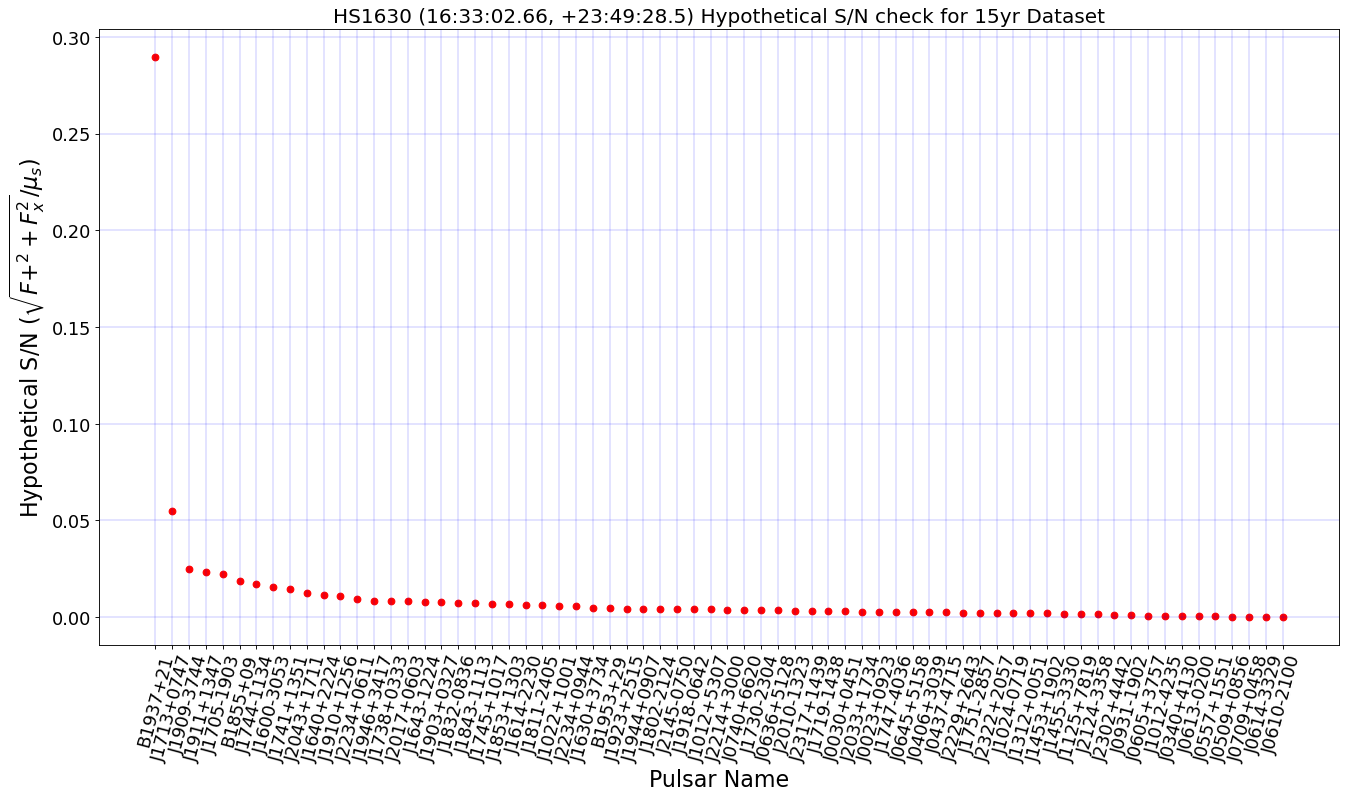

In [7]:
mock_snrs = []

psrnames,ampli = zip(*sorted(zip(psrnames,ampli)))#, reverse=True))
psrs,rms_values = zip(*sorted(zip(psrs,rms_values)))

for j in range(0,68):
    mock_snr = ampli[j]/rms_values[j]
    mock_snrs.append(mock_snr)
    
print(ampli,"\n","\n",rms_values,"\n","\n", mock_snrs)
#print(psrnames,"\n","\n",ampli)
#print(psrs,rms_values)

mock_snrs,psrnames = zip(*sorted(zip(mock_snrs,psrnames), reverse=True))

figure(figsize=(20, 10), dpi=80)
plt.scatter(psrnames,mock_snrs, c = 'r')
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.xticks(rotation = 75) # Rotates X-Axis Ticks by 45-degrees
# plt.ylim(0.03, 0.93)
plt.xlabel("Pulsar Name")
plt.ylabel("Hypothetical S/N" + r" ($\sqrt{F{+}^2 + F_{x}^2}$/$\mu_s}$)")
plt.title("HS1630 (16:33:02.66, +23:49:28.5) Hypothetical S/N check for 15yr Dataset")
'''
figure(figsize=(20, 10), dpi=80)
bottom, top = plt.ylim(0,0.6)
plt.scatter(psrnames,mock_snrs, c = 'r')
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.xticks(rotation = 75) # Rotates X-Axis Ticks by 45-degrees
# plt.ylim(0.03, 0.93)
plt.xlabel("Pulsar Name")
plt.ylabel("Hypothetical S/N" + r" ($\sqrt{F{+}^2 + F_{x}^2}$/$\mu_s}$)")
plt.title("HS1630 (16:33:02.66, +23:49:28.5) Hypothetical S/N check for 15yr Dataset (Y range set from 0 to 0.6)")
'''
plt.show()

Text(0.5, 1.0, 'HS1630 (16:33:02.66, +23:49:28.5) Hypothetical S/N check for 15yr Dataset (Y range set from 0 to 0.06)')

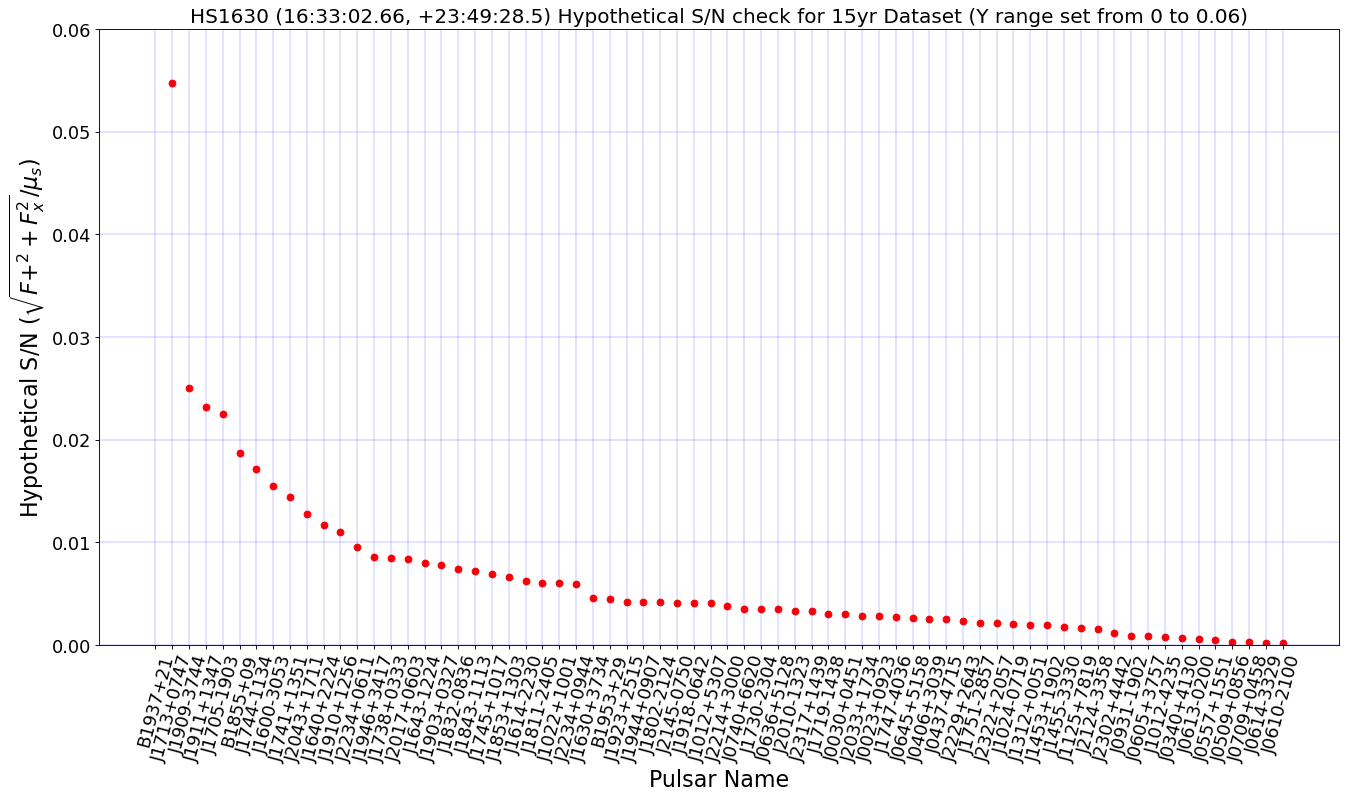

In [20]:
figure(figsize=(20, 10), dpi=80)

plt.scatter(psrnames,mock_snrs, c = 'r')
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.xticks(rotation = 75) # Rotates X-Axis Ticks by 45-degrees
plt.ylim(0,0.06)
plt.xlabel("Pulsar Name")
plt.ylabel("Hypothetical S/N" + r" ($\sqrt{F{+}^2 + F_{x}^2}$/$\mu_s}$)")
plt.title("HS1630 (16:33:02.66, +23:49:28.5) Hypothetical S/N check for 15yr Dataset (Y range set from 0 to 0.06)")

12288


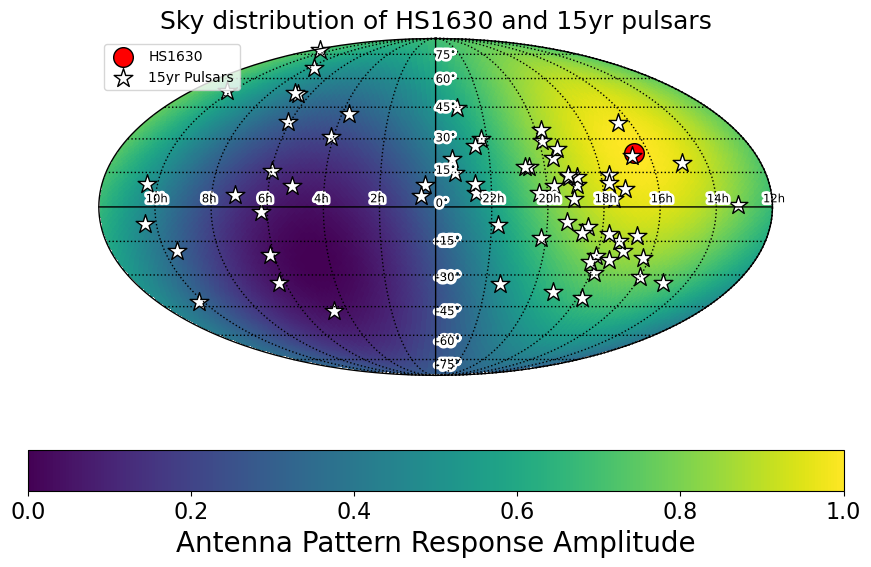

In [9]:
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
print(NPIX)
m = np.arange(NPIX)

from numpy import cos, sin
theta_pix, phi_pix = hp.pix2ang(nside=32, ipix=m)
pos_pix = np.array([sin(theta_pix)*cos(phi_pix), sin(theta_pix)*sin(phi_pix), cos(theta_pix)])

_, _, _, amp_pix = create_gw_antenna_pattern(pos_pix, gwtheta, gwphi)


hp.mollview(amp_pix,title="Sky distribution of HS1630 and 15yr pulsars", cbar = None, cmap = 'viridis', min = 0, max = 1)
hp.graticule(15,30)

hp.visufunc.projscatter(gwtheta, gwphi,marker='o',color='red',edgecolors='k',s=200, label='HS1630')


hp.visufunc.projscatter(psr_thetas, psr_phis,marker='*',color='white',edgecolors='k',s=200, label = '15yr Pulsars')

##################################################33

plt.rc('xtick',**{'labelsize':16})
plt.rc('ytick',**{'labelsize':16})
plt.rc('axes',**{'labelsize':20,'titlesize':18})

#mollview tick labels
#tick_labels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h']
#y_ticks = ['$-75^\circ$', '$-60^\circ$', '$-45^\circ$','$-30^\circ$','$-15^\circ$','$0^\circ$',
#       '$15^\circ$','$30^\circ$','$45^\circ$','$60^\circ$','$75^\circ$',]

#colorbar tick labels
cbar_ticks = [2e-15, 3e-15, 4e-15, 5e-15, 6e-15, 7e-15, 8e-15, 9e-15, 1e-14]
cbar_labels = ['$2 \times 10^{-15}$', '$3 \times 10^{-15}$', '$4 \times 10^{-15}$', ' ', '$6 \times 10^{-15}$', ' ',
           ' ' , ' ', '$10^{-14}$']

'''
#assigning number of pixels to plot
npix = hp.nside2npix(nside)

#creating mollview plot
mv = hp.mollview(skymap_smoothed, title="", cbar = None , cmap = 'viridis_r', rot = 180, norm='log',
#                        min = min(skymap11[0:768,3]), max = max(skymap11[0:768,3]),   
#                        bgcolor='white', badcolor = 'white',
                )
#drawing graticule (lines of latitude and longitude)
hp.graticule(15, 30)

#plotting candidates as points on the map
hp.visufunc.projscatter(data['Right Ascension (Decimal Degrees)'], data['Declination (Decimal Degrees)'], #data[2], data[3], 
                    lonlat=True, marker='*', color='w',edgecolors='r',s=200, zorder = 2
                       )
'''
for i in range(2,24,2):
        text = hp.projtext( i*180/12+5, 2,  str(i)+'h', lonlat=True, coord='G', fontsize = 'small', fontweight = 20, zorder = 1)
        text.set_path_effects([patheffects.withStroke(linewidth=4, foreground='w')])
    #plotting dec labels
for i in range(-75,0,15):
        text = hp.projtext( 360, i+7*i/75,  str(i)+r'$^{\circ}$', lonlat=True, coord='G', fontsize = 'small', fontweight = 20, zorder = 1)
        text.set_path_effects([patheffects.withStroke(linewidth=5, foreground='w')])
for i in range(0,90,15):
        text = hp.projtext( 360, i-3*i/75,  str(i)+r'$^{\circ}$', lonlat=True, coord='G', fontsize = 'small', fontweight = 20, zorder = 10)
        text.set_path_effects([patheffects.withStroke(linewidth=4, foreground='w')])
        
#Making colorbar for background map
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, orientation = 'horizontal', label = 'Antenna Pattern Response Amplitude' 
                    #ticks = cbar_ticks, pad = 0.05
                   )
    
###########################################################33   
plt.legend()
plt.show()
#

12288


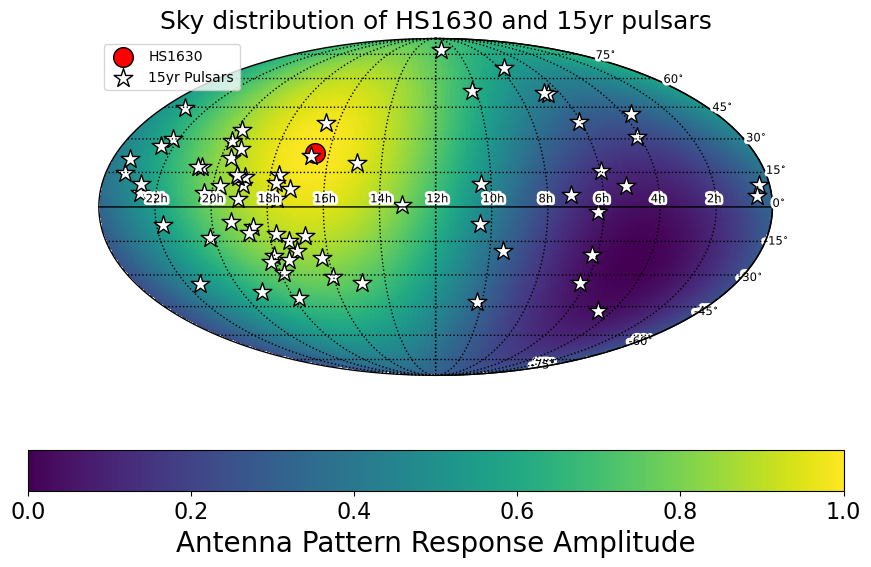

In [10]:
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
print(NPIX)
m = np.arange(NPIX)

from numpy import cos, sin
theta_pix, phi_pix = hp.pix2ang(nside=32, ipix=m)
pos_pix = np.array([sin(theta_pix)*cos(phi_pix), sin(theta_pix)*sin(phi_pix), cos(theta_pix)])

_, _, _, amp_pix = create_gw_antenna_pattern(pos_pix, gwtheta, gwphi)


hp.mollview(amp_pix,title="Sky distribution of HS1630 and 15yr pulsars", cbar = None, cmap = 'viridis', min = 0, max = 1, rot = 180)
hp.graticule(15,30)

hp.visufunc.projscatter(gwtheta, gwphi,marker='o',color='red',edgecolors='k',s=200, label='HS1630')


hp.visufunc.projscatter(psr_thetas, psr_phis,marker='*',color='white',edgecolors='k',s=200, label = '15yr Pulsars')

##################################################33

plt.rc('xtick',**{'labelsize':16})
plt.rc('ytick',**{'labelsize':16})
plt.rc('axes',**{'labelsize':20,'titlesize':18})

#mollview tick labels
#tick_labels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h']
#y_ticks = ['$-75^\circ$', '$-60^\circ$', '$-45^\circ$','$-30^\circ$','$-15^\circ$','$0^\circ$',
#       '$15^\circ$','$30^\circ$','$45^\circ$','$60^\circ$','$75^\circ$',]

#colorbar tick labels
cbar_ticks = [2e-15, 3e-15, 4e-15, 5e-15, 6e-15, 7e-15, 8e-15, 9e-15, 1e-14]
cbar_labels = ['$2 \times 10^{-15}$', '$3 \times 10^{-15}$', '$4 \times 10^{-15}$', ' ', '$6 \times 10^{-15}$', ' ',
           ' ' , ' ', '$10^{-14}$']

'''
#assigning number of pixels to plot
npix = hp.nside2npix(nside)

#creating mollview plot
mv = hp.mollview(skymap_smoothed, title="", cbar = None , cmap = 'viridis_r', rot = 180, norm='log',
#                        min = min(skymap11[0:768,3]), max = max(skymap11[0:768,3]),   
#                        bgcolor='white', badcolor = 'white',
                )
#drawing graticule (lines of latitude and longitude)
hp.graticule(15, 30)

#plotting candidates as points on the map
hp.visufunc.projscatter(data['Right Ascension (Decimal Degrees)'], data['Declination (Decimal Degrees)'], #data[2], data[3], 
                    lonlat=True, marker='*', color='w',edgecolors='r',s=200, zorder = 2
                       )
'''
for i in range(2,24,2):
        text = hp.projtext( i*180/12+5, 2,  str(i)+'h', lonlat=True, coord='G', fontsize = 'small', fontweight = 20, zorder = 1)
        text.set_path_effects([patheffects.withStroke(linewidth=4, foreground='w')])
    #plotting dec labels
for i in range(-75,0,15):
        text = hp.projtext( 360, i+7*i/75,  str(i)+r'$^{\circ}$', lonlat=True, coord='G', fontsize = 'small', fontweight = 20, zorder = 1)
        text.set_path_effects([patheffects.withStroke(linewidth=5, foreground='w')])
for i in range(0,90,15):
        text = hp.projtext( 360, i-3*i/75,  str(i)+r'$^{\circ}$', lonlat=True, coord='G', fontsize = 'small', fontweight = 20, zorder = 10)
        text.set_path_effects([patheffects.withStroke(linewidth=4, foreground='w')])
        
#Making colorbar for background map
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, orientation = 'horizontal', label = 'Antenna Pattern Response Amplitude' 
                    #ticks = cbar_ticks, pad = 0.05
                   )
    
###########################################################33   
plt.legend()
plt.show()
#

In [11]:
#hp.mollview?

In [12]:
#FOR SOURCE
#RA, DEC = (16:33:02.66, +23:49:28.5)
c = SkyCoord('04h06m00s', '+30d00m00s', frame='icrs')
print(c)
print(c.galactic)
print(c.transform_to('barycentricmeanecliptic')) #Also https://ned.ipac.caltech.edu/coordinate_calculator

<SkyCoord (ICRS): (ra, dec) in deg
    (61.5, 30.)>
<SkyCoord (Galactic): (l, b) in deg
    (165.5706947, -16.33820802)>
<SkyCoord (BarycentricMeanEcliptic: equinox=J2000.000): (lon, lat) in deg
    (65.26931381, 8.97489743)>


In [13]:
print(c.ra.radian, c.dec.radian)

1.0733774899765125 0.5235987755982988


In [14]:
#FOR PULSARS
#J0023+0923
i = '00h23m16.877s'
j = '+09d23m23.86s'
c = SkyCoord(i, j, frame='icrs')
print(c)
x = c.ra.deg
y = c.dec.deg
print(x,y)
#print(c.galactic)
#print(c.transform_to('barycentricmeanecliptic')) #Also https://ned.ipac.caltech.edu/coordinate_calculator

<SkyCoord (ICRS): (ra, dec) in deg
    (5.82032083, 9.38996111)>
5.820320833333334 9.389961111111111


In [15]:
#logger = logging.getLogger(__name__)

In [16]:
#RA, DEC = (16:33:02.66, +23:49:28.5)

i = '00h23m16.877s'
j = '+09d23m23.86s'
p = SkyCoord(i, j, frame='icrs')
#print(c[0])

RA = 248.26  #for GW source
DEC = 23.82 #for GW source
RA1 = p.ra.deg #for pulsar
DEC1 = p.dec.deg #for pulsar
print(RA1,DEC1)

gwtheta = np.pi/2 - DEC
gwphi = RA
pos = [np.cos(DEC1)* np.cos(RA1), np.cos(DEC1)* np.sin(RA1), np.sin(DEC1)]

def create_gw_antenna_pattern(pos, gwtheta, gwphi):
    """
    Function to create pulsar antenna pattern functions as defined
    in Ellis, Siemens, and Creighton (2012).
    :param pos: Unit vector from Earth to pulsar
    :param gwtheta: GW polar angle in radians
    :param gwphi: GW azimuthal angle in radians

    :return: (fplus, fcross, cosMu), where fplus and fcross
             are the plus and cross antenna pattern functions
             and cosMu is the cosine of the angle between the
             pulsar and the GW source.
    """

    # use definition from Sesana et al 2010 and Ellis et al 2012
    m = np.array([np.sin(gwphi), -np.cos(gwphi), 0.0])
    n = np.array([-np.cos(gwtheta) * np.cos(gwphi), -np.cos(gwtheta) * np.sin(gwphi), np.sin(gwtheta)])
    omhat = np.array([-np.sin(gwtheta) * np.cos(gwphi), -np.sin(gwtheta) * np.sin(gwphi), -np.cos(gwtheta)])

    fplus = 0.5 * (np.dot(m, pos) ** 2 - np.dot(n, pos) ** 2) / (1 + np.dot(omhat, pos))
    fcross = (np.dot(m, pos) * np.dot(n, pos)) / (1 + np.dot(omhat, pos))
    cosMu = -np.dot(omhat, pos)
    #Introducing amplitude (F+^2 + Fx^2)
    amplitude = (np.sqrt(np.power(fplus,2) + np.power(fcross,2)))
    
    with open('antenna_func_amplitude.txt', 'w') as f:
    # Define the data to be written
    data = amplitude
    # Use a for loop to write each line of data to the file
    for line in data:
        f.write(line + '\n')
        # Optionally, print the data as it is written to the file
        print(line)

    return fplus, fcross, cosMu, amplitude

#Function call
create_gw_antenna_pattern(pos, gwtheta, gwphi)

IndentationError: expected an indented block (2112566532.py, line 45)

In [ ]:
def test_fplus_fcross(self):
        """Check fplus, fcross generation."""
        gwtheta = 1.4
        gwphi = 2.7
        fplus, fcross, _ = utils.create_gw_antenna_pattern(self.psr.pos, gwtheta, gwphi)

        msg1 = "Fplus value incorrect"
        msg2 = "Fcross value incorrect"
        assert np.allclose(fplus, 0.161508137208), msg1
        assert np.allclose(fcross, -0.130823200124), msg2
